**Tabla de contenido**

- [Introducción](#Introduccion)
- [Requisitos](#Requisitos)
- [Lectura de datos](#Lectura-de-datos)
- [EDA](#EDA)
- [Preprocesamiento](#Preprocesamiento)
- [Respuestasa preguntas EDA](#Respuestasa-preguntas-EDA)
- [Distribucion de clases](#distribucion-de-clases)
- [Feature engineering](#Feature-engineering)
- [Outliers](#Outliers)
- [Balanceo estratificado](#Balanceo-estratificado)
- [Modelado](#Modelado)
    - [Hyperparameter Optimization](#Hyperparameter-Optimization)
        - [XGBoost Dataset balanceado](#XGBoost-Dataset-balanceado)
        - [DecisionTreeClassifier balanceado](#DecisionTreeClassifier-balanceado)
    - [Feature importance](#Feature-importance)
- [Evaluación](#Evaluacion)

# Introduccion

El objetivo de este cuaderno es preparar los datos para entrenar modelos que puedan estimar si una entrega se realizará a tiempo o será tardía. Esto implica que estamos ante un problema de clasificación binaria, donde la variable objetivo será 0 para entregas impuntuales y 1 para entregas puntuales.

No siendo mas, comencemos!!!

# Requisitos

El siguiente cuaderno fue desarrollado en un entorno de anaconda con las siguientes características:

- Python 3.12.11
- pandas: 2.3.1
- numpy: 2.3.1
- os: (built-in, sin versión)
- plotly: 6.3.0
- matplotlib: 3.10.6
- seaborn: 0.13.2
- scikit-learn: 1.7.2
- xgboost: 3.0.5
- optuna: 4.5.0

Comandos de instalación

- pip install pandas==2.3.1
- pip install numpy==2.3.1
- pip install plotly==6.3.0
- pip install nbformat ipywidgets
- pip install matplotlib==3.10.6
- pip install seaborn==0.13.2
- pip install scikit-learn==1.7.2
- pip install xgboost==3.0.5
- pip install optuna==4.5.0

# Lectura de datos

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
import os
import gc

import plotly.graph_objects as go
import plotly.express as px
import plotly.colors as pc
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import (
    HistGradientBoostingClassifier,
    BaggingClassifier
)
from sklearn.model_selection import cross_validate
import optuna
from collections import Counter
from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix
import plotly.figure_factory as ff

project_root = next(p for p in Path.cwd().parents if (p / 'data').exists()) 
file_path = lambda file : os.path.join(project_root,'data/processed',file)
data_entregas = pd.read_parquet(file_path('Dataset_cumplimiento de entregas_dis.parquet'),engine='pyarrow')
data_entregas.head()

,ID,Terminal_Origen,Terminal_Destino,Producto,Cliente,Fecha_Recogida,Fecha_Entrega,Dias_Ofrecidos,Dias_Transcurridos,Peso,Peso_Volumen,Unidades,Dept_O,Dept_D,distancia_km
0,11,6. Bucaramanga,20. Valledupar,Paquetería,AB-JABEEHEBI,2023-12-26,2024-01-01,3,4,1.0,1.00,1,Santander,La Guajira,371.425118
1,36,9. Turbaco,22. Santa Marta,Paquetería,AB-IAFAADGCG,2023-12-29,2024-01-02,1,2,1.0,1.00,1,Bolivar,Magdalena,166.757704
2,43,6. Bucaramanga,6. Bucaramanga,Paquetería,AB-DFCHBFHHB,2023-12-30,2024-01-02,1,1,2.0,0.01,1,Santander,Santander,0.000000
3,48,6. Bucaramanga,14. Monteria,Paquetería,AH-JABDDDAAH,2023-12-26,2024-01-02,2,5,1.0,0.40,1,Santander,Cordoba,353.616167
4,49,4. Pereira,23. Neiva,Paquetería,AB-DFCHBFHHB,2023-12-26,2024-01-02,5,5,2.0,0.01,1,Risaralda,Putumayo,214.688888


# EDA

El propósito principal del análisis exploratorio de datos es comprender el estado y las características de la información antes de decidir qué técnicas de ciencia de datos o machine learning aplicar. Eso implica organizar los datos, conocer su contenido, identificar las variables más relevantes y analizar como se relacionan entre sí, detectar patrones, evaluar la presencia de datos faltantes y valores atípicos y finalmente extraer conclusiones apartir de este proceso.

En general el EDA busca obtener una visión de cómo estan los datos, y para esto realizaremos las siguientes etapas:

- Consultar la cantidad de registros y columnas en la base de datos.
- Consultar los estadisticos básicos del dataframe
- Consultar los valores faltantes
- Evaluar la presencia de atípicos

Estos puntos analizados nos dan paso al preprocesamiento de los datos, con lo cual buscamos obtener una matriz limpia para responder las preguntas de investigación para el análisis exploratorio.



In [3]:
print(f"la cantidad de resgistros que tiene el dataframe son: {data_entregas.shape[0]}")
print(f"La cantidad de características son: {data_entregas.shape[1]}")

la cantidad de resgistros que tiene el dataframe son: 5156931
La cantidad de características son: 15


Podemos observar que el dataset que contiene las entregas está compuesto por `15 columnas` (características) y 5156931 registros. Veamos los estadísticos básicos de este dataset.

In [4]:
pd.set_option('display.float_format', '{:.2f}'.format)
data_entregas.describe()

,ID,Dias_Ofrecidos,Dias_Transcurridos,Peso,Peso_Volumen,Unidades,distancia_km
count,5156931.00,5156931.00,5156931.00,5156931.00,5156931.00,5156931.00,5156931.00
mean,2579292.50,2.14,2.93,8.85,14.64,1.21,294.68
std,1489066.37,1.33,4.85,142.39,88.68,5.77,213.60
min,1.00,1.00,0.00,0.01,0.00,1.00,0.00
25%,1289634.50,1.00,1.00,1.00,0.57,1.00,113.95
50%,2579646.00,2.00,2.00,1.00,1.00,1.00,283.03
75%,3868880.50,3.00,3.00,7.00,12.00,1.00,435.55
max,5158113.00,17.00,724.00,249615.00,32986.80,1817.00,1246.02


Veamos si este dataset tiene datos faltantes.

In [5]:
data_entregas.isnull().sum()

ID                    0
Terminal_Origen       0
Terminal_Destino      0
Producto              0
Cliente               0
Fecha_Recogida        0
Fecha_Entrega         0
Dias_Ofrecidos        0
Dias_Transcurridos    0
Peso                  0
Peso_Volumen          0
Unidades              0
Dept_O                0
Dept_D                0
distancia_km          0
dtype: int64

Perfecto!!!

No tenemos que preocuparnos por los datos faltantes. Veamos si hay valores duplicados

In [6]:
print(f"Duplicados (sin contar la primera aparición): {data_entregas.duplicated().sum()}")

Duplicados (sin contar la primera aparición): 0


Esto es positivo; no hay registros duplicados. Ahora, examinemos qué tipos de datos contiene el dataframe.

In [7]:
data_entregas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5156931 entries, 0 to 5156930
Data columns (total 15 columns):
 #   Column              Dtype  
---  ------              -----  
 0   ID                  int64  
 1   Terminal_Origen     object 
 2   Terminal_Destino    object 
 3   Producto            object 
 4   Cliente             object 
 5   Fecha_Recogida      object 
 6   Fecha_Entrega       object 
 7   Dias_Ofrecidos      int64  
 8   Dias_Transcurridos  int64  
 9   Peso                float64
 10  Peso_Volumen        float64
 11  Unidades            int64  
 12  Dept_O              object 
 13  Dept_D              object 
 14  distancia_km        float64
dtypes: float64(3), int64(4), object(8)
memory usage: 590.2+ MB


Ok, podemos observar que en este dataset tenemos varias variables de tipo object.


# Preprocesamiento

Dado que el propósito de este cuaderno es entrenar un modelo de clasificación binaria para estimar si una entrega se realizará a tiempo o será tardía, es fundamental crear la variable objetivo.

En este contexto, la variable objetivo se calculará de la siguiente manera:

- Si Días_Transcurridos > Días_Ofrecidos, la etiqueta será 0 (tardía).
- Si Días_Transcurridos <= Días_Ofrecidos, la etiqueta será 1 (a tiempo).

Finalmente, eliminaremos las variables Días_Transcurridos, Cliente y Fecha de Entrega para asegurarnos de que el modelo no tenga acceso a información futura.

In [8]:

entregas = data_entregas.drop(columns=['Cliente',
                                       'Fecha_Entrega'],
                                       axis=1).copy()
entregas['target'] = np.where(entregas['Dias_Transcurridos'] <= entregas['Dias_Ofrecidos'], 1, 0)
entregas = entregas.drop(columns=['Dias_Transcurridos','ID'],axis=1)

Perfecto, liberemos memoria y transformemos la fecha a formato datetime.

In [9]:
del data_entregas
entregas['Fecha_Recogida'] = pd.to_datetime(entregas['Fecha_Recogida'],format='%Y-%m-%d')
entregas = entregas.sort_values(by=['Terminal_Destino', 'Fecha_Recogida'])

In [10]:
entregas.head()

,Terminal_Origen,Terminal_Destino,Producto,Fecha_Recogida,Dias_Ofrecidos,Peso,Peso_Volumen,Unidades,Dept_O,Dept_D,distancia_km,target
1192195,23. Neiva,11. Pasto,Paquetería,2023-10-30,2,2.00,1.00,1,Huila,Nariño,292.68,0
2781124,12. Cucuta,11. Pasto,Paquetería,2023-11-07,5,2.00,0.01,1,Norte de Santander,Nariño,911.81,0
397706,5. Ibague,11. Pasto,Paquetería,2023-11-09,4,1.00,0.40,1,Tolima,Nariño,424.72,0
4414205,24. Rionegro,11. Pasto,Paquetería,2023-11-10,4,2.00,1.00,1,Antioquia,Nariño,588.80,0
797647,12. Cucuta,11. Pasto,Paquetería,2023-11-11,5,2.00,1.75,1,Norte de Santander,Nariño,911.81,0


A las variableas categóricas, les voy a asignar el tipo de dato como categórico.

In [11]:
entregas['Terminal_Origen'] = entregas['Terminal_Origen'].astype('category')
entregas['Terminal_Destino'] = entregas['Terminal_Destino'].astype('category')
entregas['Producto'] = entregas['Producto'].astype('category')

entregas['Dept_O'] = entregas['Dept_O'].astype('category')
entregas['Dept_D'] = entregas['Dept_D'].astype('category')


# Respuestasa preguntas EDA

Ahora que hemos comprendido la estructura y características de los datos, es momento de abordar las preguntas de investigación planteadas para este análisis exploratorio.

1. ¿Cuáles son los tipos de productos que se entregan con mayor puntualidad?
2. ¿En qué terminales de destino, y que productos tienen el mayor porcentaje de cumplimiento?
3. ¿Cuáles son los meses en los que llegan más productos a enviar? 
4. ¿Qué días del mes hay más envios?
5. ¿Qué días de la semana hay menos envios?

Bueno, antes de dar respuesta a esta pregunta, definamos la función que gráficará los resultados que vamos a obtener.

In [12]:
def crear_barplot_personalizado(df, x, y, color, decimales, titulo=''):
    bar_fig = px.bar(
        df,
        x=x,
        y=y,
        color=color,
        color_discrete_sequence=px.colors.qualitative.Dark2,
        barmode='stack',  # Cambiar de 'group' a 'stack'
        text=y,
        labels={x: ' ', y: 'Porcentaje'},
    )

    # Personalización del gráfico
    bar_fig.update_traces(textposition='outside', texttemplate=decimales,
                          textfont=dict(family='Arial', size=14, color='black', weight='bold'))
    bar_fig.update_layout(
        plot_bgcolor='white',
        paper_bgcolor='white',
        title=titulo,
        title_x=0.5,
        title_font=dict(size=18, family='Arial', color='black'),
        xaxis=dict(
            title_font=dict(size=14, family='Arial', color='black'),
            tickfont=dict(size=10, family='Arial', color='black', weight='bold'),
            showgrid=True,
            gridcolor='lightgrey',
            zerolinecolor='lightgrey',
        ),
        yaxis=dict(
            title='',
            tickfont=dict(size=12, family='Arial', color='black', weight='bold'),
            autorange=True,
            ticklen=10,
            showline=True,
            linecolor='black',
            automargin=True,
            ticksuffix='   ',
        ),
        hoverlabel=dict(
            bgcolor='white',
            font_size=12,
            font_family='Arial'
        ),
        showlegend=True,
        legend=dict(
            orientation='h',
            yanchor='bottom',
            y=1.05,
            xanchor='center',
            x=0.5,
            font=dict(size=10)
        ),
        bargap=0.2,
    )

    return bar_fig


Ahora si, ¿Cuáles son los tipos de productos que se entregan con mayor puntualidad?

In [13]:
puntualidad = entregas.groupby(by=['Producto','target'],observed=False).agg(
    count_puntual = ('target','count')
).reset_index()
puntualidad['Porcentaje'] = (puntualidad['count_puntual']/puntualidad['count_puntual'].sum())*100
puntualidad = puntualidad.sort_values(
    by='Porcentaje',  # Columna por la que ordenar
    ascending=False   # Orden descendente (de mayor a menor)
).reset_index(drop=True)

fig = crear_barplot_personalizado(puntualidad, 
                                  x='Producto', 
                                  y='Porcentaje', 
                                  color='target',
                                  decimales ='%{y:.2f}%',
                                  titulo='Porcentaje de cumplimiento en entregas por producto')
fig.show()

Ok, podemos observar que en todos los productos, la mayoria de las entregas se realizan a tiempo.

Veamos ahora, ¿En qué terminales de destino, y que productos tienen el mayor porcentaje de cumplimiento?


In [14]:
puntualidad = entregas.groupby(by=['Terminal_Destino','Producto','target'],observed=True).agg(
    count_puntual = ('target','count')
).reset_index()
puntualidad['Porcentaje'] = (puntualidad['count_puntual']/puntualidad['count_puntual'].sum())*100
puntualidad = puntualidad.sort_values(
    by='Porcentaje',  # Columna por la que ordenar
    ascending=False   # Orden descendente (de mayor a menor)
).reset_index(drop=True)


In [15]:
puntualidad['Producto_Target'] = (
    puntualidad['Producto'].astype(str) + ' - ' + puntualidad['target'].astype(str)
)
categorias_en_datos = puntualidad['Producto_Target'].unique().tolist()

orden_base = [
    'Paquetería - 1',
    'Paquetería - 0',
    'Mercancía - 1',
    'Mercancía - 0',
    'Mercancía XL - 1',
    'Mercancía XL - 0'
]
categorias_en_datos = puntualidad['Producto_Target'].unique().tolist()
orden_final = [cat for cat in orden_base if cat in categorias_en_datos]

puntualidad['Producto_Target'] = pd.Categorical(
    puntualidad['Producto_Target'],
    categories=orden_final,
    ordered=True
)

puntualidad = puntualidad.sort_values(
    by=['Terminal_Destino', 'Producto_Target'],
    ascending=[True, True]
).reset_index(drop=True)

fig = crear_barplot_personalizado(puntualidad, 
                                   x='Terminal_Destino', 
                                   y='Porcentaje', 
                                   color='Producto_Target',
                                   decimales='%{y:.2f}%',
                                   titulo='')

# Muestra la figura
fig.show()


Perfecto, podemos ver sin importar la terminal de destino, el porcentaje de cumplimiento por producto, supera al de incumplimiento, asi que muy probablemente, tenemos un desbalance en la clase de cumplimiento e incumplimiento.

Guardemos en un archivo parquet los datos que tenemos, agregemos la fecha de recogida como variable predictora y veamos, ¿Cuáles son los meses en los que llegan más productos a enviar? 


In [16]:
dir_save_data = project_root/'data/processed'
entregas.to_parquet(dir_save_data/ 'Dataset_cumplimiento de entregas.parquet', index=False)

In [17]:
entregas['day'] = entregas['Fecha_Recogida'].dt.day
entregas['month'] = entregas['Fecha_Recogida'].dt.month
entregas['year'] = entregas['Fecha_Recogida'].dt.year
entregas['week'] = entregas['Fecha_Recogida'].dt.isocalendar().week

In [18]:
productos_meses = entregas.groupby(by=['Producto','month'],observed=False).agg(
    sum_unidades = ('Unidades','sum')
).reset_index()

productos_meses['Porcentaje'] = (productos_meses['sum_unidades']/productos_meses['sum_unidades'].sum())*100
productos_meses = productos_meses.sort_values(
    by='Porcentaje',  # Columna por la que ordenar
    ascending=False   # Orden descendente (de mayor a menor)
).reset_index(drop=True)


meses = {
    1: "Enero",
    2: "Febrero",
    3: "Marzo",
    4: "Abril",
    5: "Mayo",
    6: "Junio",
    7: "Julio",
    8: "Agosto",
    9: "Septiembre",
    10: "Octubre",
    11: "Noviembre",
    12: "Diciembre"
}

productos_meses['month'] = productos_meses['month'].map(meses)
fig = crear_barplot_personalizado(productos_meses, 
                                   x='month', 
                                   y='Porcentaje', 
                                   color='Producto',
                                   decimales='%{y:.2f}%',
                                   titulo='')

fig.show()

Los meses con mayor cantidad de envíos son octubre, septiembre, agosto y julio, mientras que noviembre registra el menor número de envíos.

Veamos ahora que días del mes hay más envios.

In [19]:
productos_dias = entregas.groupby(by=['Producto','day'],observed=False).agg(
    sum_unidades = ('Unidades','sum')
).reset_index()

productos_dias['Porcentaje'] = (productos_dias['sum_unidades']/productos_dias['sum_unidades'].sum())*100
productos_dias = productos_dias.sort_values(
    by='Porcentaje',  # Columna por la que ordenar
    ascending=False   # Orden descendente (de mayor a menor)
).reset_index(drop=True)

fig = crear_barplot_personalizado(productos_dias, 
                                   x='day', 
                                   y='Porcentaje', 
                                   color='Producto',
                                   decimales='%{y:.2f}%',
                                   titulo='')
fig.show()

Ok, al parecer hay muchos envíos todos los días. Pero, ¿qué días de la semana hay menos envíos?

In [20]:
entregas['dia_semana'] = entregas['Fecha_Recogida'].dt.day_name(locale='es_ES')
productos_dias = entregas.groupby(by=['Producto','dia_semana'],observed=False).agg(
    sum_unidades = ('Unidades','sum')
).reset_index()

productos_dias['Porcentaje'] = (productos_dias['sum_unidades']/productos_dias['sum_unidades'].sum())*100
productos_dias = productos_dias.sort_values(
    by='Porcentaje',  # Columna por la que ordenar
    ascending=False   # Orden descendente (de mayor a menor)
).reset_index(drop=True)

fig = crear_barplot_personalizado(productos_dias, 
                                   x='dia_semana', 
                                   y='Porcentaje', 
                                   color='Producto',
                                   decimales='%{y:.2f}%',
                                   titulo='')
fig.show()

Los días de la semana con menor actividad son los sábados y domingos.

Ahora que tenemos una idea general sobre los datos, verifiquemos si las clases están equilibradas.

# distribucion de clases

In [21]:
def plotbar(df, y, x, colors, labels, text_fmt, title):
    fig = px.bar(
        df,
        y=y,
        x=x,
        orientation='h',
        labels=labels,
        title=title,
        color_discrete_sequence=colors,
        color=y,
        text_auto='.2f',
        height=500,  # 
    )

    fig.update_traces(
        texttemplate=text_fmt,
        textposition='outside',
        textfont=dict(size=11, family='Arial', color='black'),
        marker=dict(line=dict(width=1, color='white'))  
    )

    fig.update_layout(
        title=dict(
            x=0.5,
            font=dict(size=20, family='Arial', color='#2C3E50'),
            y=0.95
        ),
        plot_bgcolor='white',
        paper_bgcolor='white',
        showlegend=False,
        bargap=0.4,  
        bargroupgap=0.1,
        margin=dict(t=80, b=60, l=60, r=40),
        xaxis=dict(
            title_font=dict(size=14, family='Arial', color='#2C3E50'),
            tickfont=dict(size=11, family='Arial', color='#7F8C8D'),
            showgrid=True,
            gridcolor='#ECF0F1',
            zerolinecolor='#BDC3C7',
            zerolinewidth=1,
            showline=True,
            linecolor='#BDC3C7',
            linewidth=1,
            tickformat=',.0%'  
        ),
        yaxis=dict(
            title='',
            tickfont=dict(size=12, family='Arial', color='#2C3E50', weight='bold'),
            autorange='reversed',
            ticklen=0,
            showline=True,
            linecolor='#BDC3C7',
            linewidth=1,
            automargin=True,
            ticksuffix="   ",
            tickmode='array',
            tickvals=[0, 1],
            ticktext=['Clase 0', 'Clase 1'] 
        ),
        hoverlabel=dict(
            bgcolor='white',
            font_size=12,
            font_family='Arial',
            bordercolor='#BDC3C7'
        ),
        font=dict(family='Arial'),
        separators=',.',
        hovermode='closest'
    )
    fig.update_coloraxes(showscale=False)
    
    return fig

In [22]:
count_clases = entregas['target'].value_counts(normalize=True).reset_index()
count_clases.columns = ['Clase', 'Proporcion']

bar_fig = plotbar(
    df=count_clases,
    y='Clase',              
    x='Proporcion',        
    colors=pc.qualitative.Plotly,
    labels={'Proporcion': 'Proporción'},
    text_fmt='<b>%{x:.2%}</b>',   # mostrar como porcentaje con 2 decimales
    title='Distribución de la variable objetivo'
)

bar_fig.show()

Entendido.

Las clases están desequilibradas, lo que implica dos aspectos importantes.

Si entrenamos un modelo con estos datos tal como están, es probable que sea muy efectivo para predecir si se cumplirá con la entrega en el tiempo estipulado, pero tendrá dificultades para identificar posibles incumplimientos.

Ante esta situación, tenemos dos opciones: submuestrear la clase mayoritaria o generar datos sintéticos para la clase minoritaria.

Por el momento agreguemos otras variables predictoras.

# Feature engineering

Dado que ya hemos abordado algunas de las preguntas planteadas en el análisis exploratorio, es momento de codificar las variables categóricas, teniendo en cuenta su naturaleza.

- `Variables Ordinales`: Estas son las variables categóricas que poseen un orden intrínseco o jerárquico. Su codificación se realiza manualmente, asignando valores que reflejan este orden.

- `Variables Nominales`: Estas variables categóricas no tienen un orden o jerarquía implícita, lo que significa que no se pueden codificar manualmente. Para ello, utilizaremos la codificación one-hot encoder, que convierte las categorías en variables dummy. La ventaja de este método es que garantiza que cada vector de características sea ortogonal a los demás, lo que implica que el producto punto entre dos vectores de características diferentes sea cero. Además, esta codificación asegura que la norma de estos vectores de características sea igual a 1. Estas dos propiedades de la codificación garantizan que no se creen relaciones internas entre las características. No obstante si las variables son muchas, llegariamos al problema de la `Alta dumensionalidad` y esto no es bueno, por eso muchas veces es necesario analizar cual codificación es más apropiada según el problema.

Veamos cuantas categorias únicas hay en la variable `Terminal_Destino`.

In [23]:
entregas['Terminal_Destino'].unique()

['11. Pasto', '12. Cucuta', '13. Manizales', '14. Monteria', '15. Buenaventura', ..., '4. Pereira', '5. Ibague', '6. Bucaramanga', '8. Sincelejo', '9. Turbaco']
Length: 29
Categories (29, object): ['11. Pasto', '12. Cucuta', '13. Manizales', '14. Monteria', ..., '5. Ibague', '6. Bucaramanga', '8. Sincelejo', '9. Turbaco']

A continuación, realizaremos lo siguiente:

Codificaremos todas las terminales, productos, y dias de la semana como variables ordinales. De esta manera, aseguraremos que no alcanzamos una alta dimensionalidad y probaremos si un modelo por defecto logra obtener una buena puntuación.

In [23]:
cod_terminal = {
    terminal: int(terminal.split('.')[0])
    for terminal in entregas['Terminal_Destino']
}

entregas['Terminal_Destino'] = entregas['Terminal_Destino'].map(cod_terminal).astype(int)

In [24]:
cod_terminal_o = {
    terminal: int(terminal.split('.')[0])
    for terminal in entregas['Terminal_Origen']
}
entregas['Terminal_Origen'] = entregas['Terminal_Origen'].map(cod_terminal).astype(int)

In [25]:
dict_producto ={
    'Paquetería':3,
    'Mercancía':2,
    'Mercancía XL':1
}

entregas['Producto'] = entregas['Producto'].map(dict_producto).astype(int)

In [26]:
dict_dia_semana={
    'Lunes':1,
    'Martes':2,
    'Miércoles':3,
    'Jueves':4,
    'Viernes':5,
    'Sábado':6,
    'Domingo':7
}

entregas['dia_semana'] = entregas['dia_semana'].map(dict_dia_semana).astype(int)

In [27]:
entregas.head()

,Terminal_Origen,Terminal_Destino,Producto,Fecha_Recogida,Dias_Ofrecidos,Peso,Peso_Volumen,Unidades,Dept_O,Dept_D,distancia_km,target,day,month,year,week,dia_semana
1192195,23,11,3,2023-10-30,2,2.00,1.00,1,Huila,Nariño,292.68,0,30,10,2023,44,1
2781124,12,11,3,2023-11-07,5,2.00,0.01,1,Norte de Santander,Nariño,911.81,0,7,11,2023,45,2
397706,5,11,3,2023-11-09,4,1.00,0.40,1,Tolima,Nariño,424.72,0,9,11,2023,45,4
4414205,24,11,3,2023-11-10,4,2.00,1.00,1,Antioquia,Nariño,588.80,0,10,11,2023,45,5
797647,12,11,3,2023-11-11,5,2.00,1.75,1,Norte de Santander,Nariño,911.81,0,11,11,2023,45,6


Veamos si hay valores atípicos.

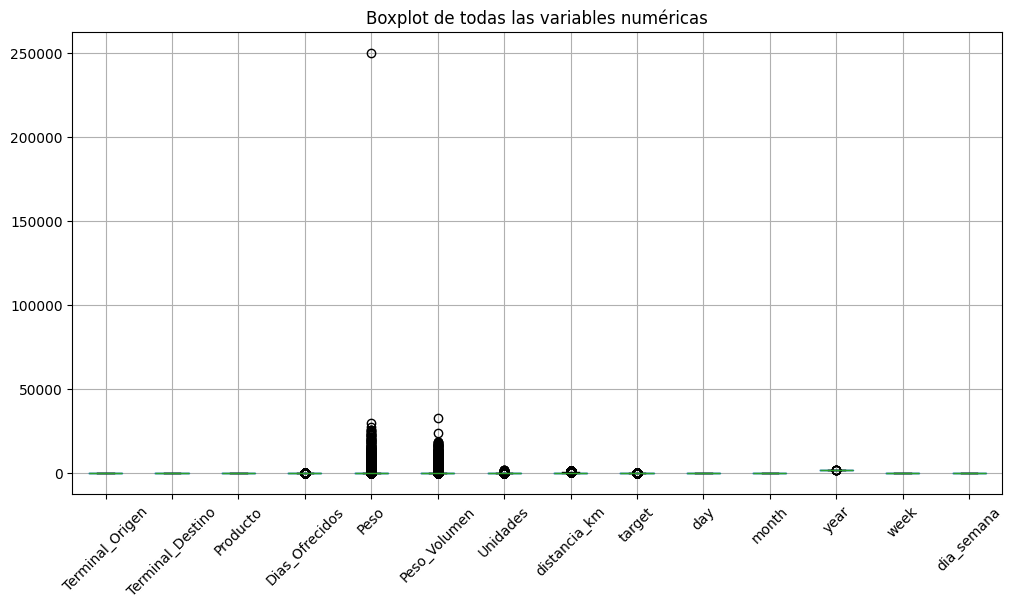

12546

In [28]:
df=entregas.drop(columns=['Dept_O','Dept_D','Fecha_Recogida'], axis=1)
df.boxplot(figsize=(12, 6))
plt.title("Boxplot de todas las variables numéricas")
plt.xticks(rotation=45)
plt.show()
del df
gc.collect()

# Outliers

En esta etapa eliminaremos los valores atípicos utilizando el rango intercuartílico, y lo haremos para las columnas Peso y Peso_Volumen.

In [29]:
# --- OUTLIERS PARA PESO ---
Q1_p = entregas["Peso"].quantile(0.25)
Q3_p = entregas["Peso"].quantile(0.75)
IQR_p = Q3_p - Q1_p

lim_inf_p = Q1_p - 1.5 * IQR_p
lim_sup_p = Q3_p + 1.5 * IQR_p

# --- OUTLIERS PARA PESO_VOLUMEN ---
Q1_v = entregas["Peso_Volumen"].quantile(0.25)
Q3_v = entregas["Peso_Volumen"].quantile(0.75)
IQR_v = Q3_v - Q1_v

lim_inf_v = Q1_v - 1.5 * IQR_v
lim_sup_v = Q3_v + 1.5 * IQR_v

entregas = entregas[
    (entregas["Peso"] >= lim_inf_p) & (entregas["Peso"] <= lim_sup_p) &
    (entregas["Peso_Volumen"] >= lim_inf_v) & (entregas["Peso_Volumen"] <= lim_sup_v)
]

Ahora incorporamos nuevas variables derivadas con el objetivo de enriquecer el análisis y capturar relaciones relevantes entre distancia, peso, volumen y características del producto. Las variables creadas son las siguientes:

- dias-distancia: representa la distancia recorrida por cada día ofrecido, calculada como distancia_km / Dias_Ofrecidos.

- distancia_por_peso_volumen: mide el impacto combinado de la distancia y el peso-volumen del envío mediante el producto distancia_km * Peso_Volumen.

- producto_distancia: refleja la relación entre el tipo de producto y la distancia recorrida, calculada como Producto * distancia_km.

- carga_sensible_distancia: cuantifica la distancia recorrida por cargas sensibles o especiales, utilizando también Producto * distancia_km.

- riesgo_logistico: estima un indicador de riesgo basado en peso, distancia y número de unidades, definido como Peso * distancia_km * Unidades.

In [30]:
entregas['dias-distancia']=entregas['distancia_km']/entregas['Dias_Ofrecidos']
entregas['distancia_por_peso_volumen'] = entregas['distancia_km'] * entregas['Peso_Volumen']
entregas['producto_distancia'] = entregas['Producto'] * entregas['distancia_km']
entregas['carga_sensible_distancia'] = entregas['Producto'] * entregas['distancia_km']
entregas['riesgo_logistico'] = entregas['Peso'] * entregas['distancia_km']* entregas['Unidades']

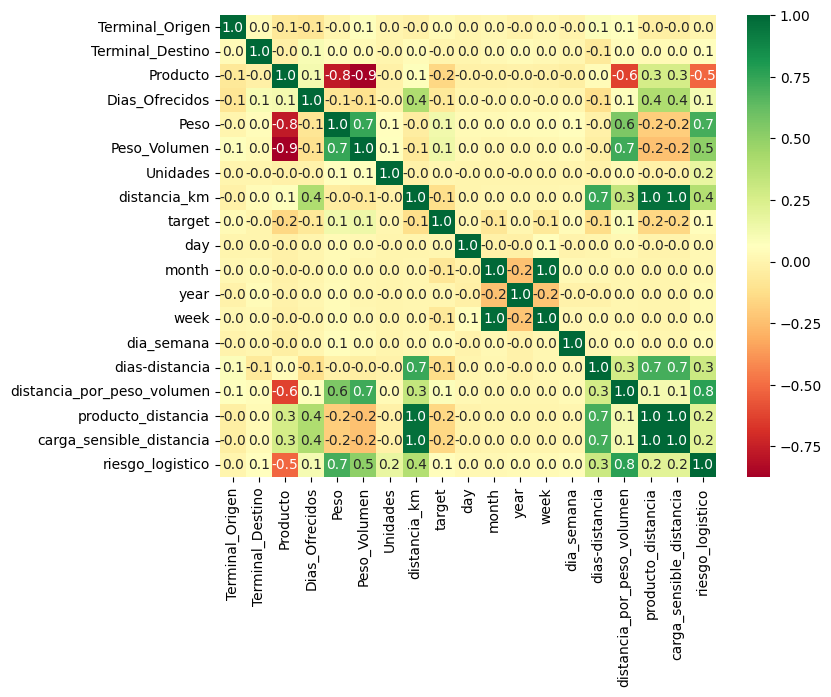

In [31]:
plt.figure(figsize=(8, 6))  
sns.heatmap(
    entregas.select_dtypes(include=['number']).corr(),
    annot=True,
    fmt=".1f",         # Un decimal en las anotaciones
    cmap='RdYlGn',
    cbar=True 
)
plt.show()

In [32]:
gc.collect()

27643

Probemos que tan bien se comporta el modelo si no le digo que las clases están desbalanceadas, yo espero que tenga bueno resultados hacia la clase mayoritaria.

In [33]:
independientes = entregas.drop(columns=['target','Fecha_Recogida','Dept_O','Dept_D'], axis=1) 
objetivo = entregas['target']   
X_train, X_test, Y_train, Y_test = train_test_split(
    independientes,
    objetivo,
    test_size=0.2,
    random_state=42,
    shuffle=True,
    stratify=objetivo 
)

def model(Y_test, Y_train, X_test, X_train, model):
    model_instance = model()
    model_instance.fit(X_train, Y_train)
    y_pred = model_instance.predict(X_test)
    
    # Métricas generales
    acc = accuracy_score(Y_test, y_pred)
    prec = precision_score(Y_test, y_pred)
    rec = recall_score(Y_test, y_pred)
    f1 = f1_score(Y_test, y_pred)
    
    # Crear diccionario con resultados
    results = {
        'Model': type(model_instance).__name__,
        'Accuracy': round(acc, 4),
        'Precision': round(prec, 4),
        'Recall': round(rec, 4),
        'F1-Score': round(f1, 4),
    }
    
    # Devolver tanto el modelo como los resultados
    return model_instance, results

# Ejecutar modelos y recolectar resultados
models = [
    XGBClassifier,
    DecisionTreeClassifier   
]
trained_models = []
results_list = []

for model_class in models:
    model_instance, results = model(Y_test, Y_train, X_test, X_train, model_class)
    trained_models.append(model_instance)
    results_list.append(results)

# Convertir a DataFrame
results_df = pd.DataFrame(results_list)

# Ordenar por Acuracy (de mayor a menor)
results_df = results_df.sort_values('Accuracy', ascending=False)
results_df.head(len(results_df))

,Model,Accuracy,Precision,Recall,F1-Score
0,XGBClassifier,0.78,0.80,0.95,0.87
1,DecisionTreeClassifier,0.76,0.84,0.83,0.83


Como era de esperar, un modelo entrenado con todos estos datos identifica correctamente la clase mayoritaria. Veamos qué sucede al indicarle que las clases están desbalanceadas

In [34]:
gc.collect()

2

In [35]:

independientes = entregas.drop(columns=['target','Fecha_Recogida','Dept_O','Dept_D'], axis=1) 
objetivo = entregas['target']  

X_train, X_test, Y_train, Y_test = train_test_split(
    independientes,
    objetivo,
    test_size=0.2,
    random_state=42,
    shuffle=True,
    stratify=objetivo
)

# ================================
# 2. Calcular class_weight para modelos sklearn
# ================================
clases = np.unique(Y_train)

pesos = compute_class_weight(
    class_weight='balanced',
    classes=clases,
    y=Y_train
)

class_weights = dict(zip(clases, pesos))
print("Class weights:", class_weights)


# ================================
# 3. Calcular scale_pos_weight para XGBoost
# ================================
n_pos = sum(Y_train == 1)
n_neg = sum(Y_train == 0)
scale_pos_weight = n_neg / n_pos

print("scale_pos_weight (XGB):", scale_pos_weight)


# ================================
# 4. Función para entrenar y medir
# ================================
def model(Y_test, Y_train, X_test, X_train, model_instance):
    model_instance.fit(X_train, Y_train)
    y_pred = model_instance.predict(X_test)

    acc = accuracy_score(Y_test, y_pred)
    prec = precision_score(Y_test, y_pred, zero_division=0)
    rec = recall_score(Y_test, y_pred, zero_division=0)
    f1 = f1_score(Y_test, y_pred, zero_division=0)

    results = {
        'Model': type(model_instance).__name__,
        'Accuracy': round(acc, 4),
        'Precision': round(prec, 4),
        'Recall': round(rec, 4),
        'F1-Score': round(f1, 4),
    }
    
    return model_instance, results


# ==================================================
# 5. Lista de modelos 
# ==================================================
model_list = [
    DecisionTreeClassifier(class_weight=class_weights),
    XGBClassifier(scale_pos_weight=scale_pos_weight, eval_metric="logloss"),  # XGB balanceado
]


# ================================
# 6. Entrenar y guardar resultados
# ================================
trained_models = []
results_list = []

for m in model_list:
    model_instance, results = model(Y_test, Y_train, X_test, X_train, m)
    trained_models.append(model_instance)
    results_list.append(results)

results_df = pd.DataFrame(results_list)
results_df = results_df.sort_values('F1-Score', ascending=False)

results_df


Class weights: {np.int64(0): np.float64(1.9215040844429083), np.int64(1): np.float64(0.6758700539351428)}
scale_pos_weight (XGB): 0.3517401078702855


,Model,Accuracy,Precision,Recall,F1-Score
0,DecisionTreeClassifier,0.74,0.85,0.79,0.82
1,XGBClassifier,0.71,0.87,0.72,0.79


ok, esto es bueno, el f1 escore es del 82%.

In [36]:
gc.collect()

0


Veamos si al submuestrear mejoramos el F1 score.

# Balanceo estratificado

In [37]:
entregas['target'].value_counts()

target
1    3238844
0    1139232
Name: count, dtype: int64

In [38]:
class0 = entregas[entregas['target']==0]
class1 = entregas[entregas['target']==1]

clase_1_sub, _ = train_test_split(
    class1 ,
    train_size=1139232, 
    stratify=class1 ['Terminal_Destino'],  # estratificación
    random_state=43,
    shuffle=True
)
clase_1_sub.shape

(1139232, 22)

In [39]:
df_submuestreado_estr = pd.concat([clase_1_sub,class0],axis=0)
df_submuestreado_estr = df_submuestreado_estr.sample(frac=1, random_state=42).reset_index(drop=True)
df_submuestreado_estr['target'].value_counts()

df_submuestreado_estr = df_submuestreado_estr.drop(columns=['Dept_O','Dept_D','Fecha_Recogida'], axis=1) 

In [40]:
gc.collect()

0

Definamos las nuevas variables objetivos con el dataset balanceado y entrenemos los modelos

In [41]:
independientes =df_submuestreado_estr.drop(['target'],axis=1)
objetivo = df_submuestreado_estr['target']

In [42]:
X_train, X_test, Y_train, Y_test = train_test_split(
    independientes,
    objetivo,
    test_size=0.2,
    random_state=42,
)

def model(Y_test, Y_train, X_test, X_train, model):
    model_instance = model()
    model_instance.fit(X_train, Y_train)
    y_pred = model_instance.predict(X_test)
    
    # Métricas generales
    acc = accuracy_score(Y_test, y_pred)
    prec = precision_score(Y_test, y_pred)
    rec = recall_score(Y_test, y_pred)
    f1 = f1_score(Y_test, y_pred)
    
    # Crear diccionario con resultados
    results = {
        'Model': type(model_instance).__name__,
        'Accuracy': round(acc, 4),
        'Precision': round(prec, 4),
        'Recall': round(rec, 4),
        'F1-Score': round(f1, 4),
    }
    
    # Devolver tanto el modelo como los resultados
    return model_instance, results

# Ejecutar modelos y recolectar resultados
models = [
    DecisionTreeClassifier,
    XGBClassifier,

]
trained_models = []
results_list = []

for model_class in models:
    model_instance, results = model(Y_test, Y_train, X_test, X_train, model_class)
    trained_models.append(model_instance)
    results_list.append(results)

# Convertir a DataFrame
results_df = pd.DataFrame(results_list)

# Ordenar por Acuracy (de mayor a menor)
results_df = results_df.sort_values('Accuracy', ascending=False)
results_df.head(len(results_df))

,Model,Accuracy,Precision,Recall,F1-Score
1,XGBClassifier,0.71,0.70,0.72,0.71
0,DecisionTreeClassifier,0.69,0.70,0.65,0.68


In [43]:
gc.collect()

0

"Ok, al submuestrear los datos el modelo baja el rendimiento en un 10 porciento", indicando que realmente puede detectar solo el 70% de los envío que no cumplirán con los días pactados.

# Modelado

Ya conocemos nuestros datos y entendemos que, si entrenamos un modelo con un conjunto de datos altamente desbalanceado, este tenderá a sesgarse hacia la clase mayoritaria.
En nuestro caso, al aplicar un balanceo de las clases, observamos que los resultados no mejoran de manera significativa.

Ahora bien, surge la pregunta: ¿qué métrica debemos utilizar para evaluar el desempeño del modelo?

Para responderla, revisemos primero las definiciones matemáticas de las principales métricas de evaluación:

 1. Precisión (Precision): Indica la habilidad del modelo para clasificar como postivo los casos que son positivos.

$\text{Precision} = \frac{TP}{TP + FP}$


- **TP (True Positives):** positivos correctamente predichos.  
- **FP (False Positives):** negativos predichos como positivos.


2. Recall (Sensibilidad): Nos da una medida de la habilidad del modelo para encontrar todos los casos positivos. Esta se mide en función de una clase.

$\text{Recall} = \frac{TP}{TP + FN}$


- **TP (True Positives):** positivos correctamente predichos.  
- **FN (False Negatives):** positivos no detectados por el modelo.


 3. Exactitud (Accuracy): Es la medida general de como se comporta el modelo, mide simplemente el porcentaje de casos que se han clasificado correctamente. No es un buen criterio para decir que el modelo es bueno.

$\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}$


- **TN (True Negatives):** negativos correctamente predichos.  
- **FP (False Positives):** negativos predichos como positivos.  
- **FN (False Negatives):** positivos no detectados.  


4. F1-Score: Combina precisión y recall en un solo número, es una muy buena métrica.

$F1 = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}$


- Combina precisión y recall en un solo valor, útil para problemas con clases desbalanceadas.


**Clases balanceadas:** Se puede usar:

- **accuracy (Exactitud)** Mide los casos que se han clasificado correctamente. Ideal cuando todas las clases son de igual importancia.
- **f1_micro:** Útil cuando interesa el rendimiento general del modelo.
- **roc_auc_ovr:** Útil para evaluar el rendimiento de clasificadores binarios y multiclase.


**Clases desbalanceadas:** Se puede usar:

- **f1_weighted:** Refleja mejor rendimiento en un conjunto de datos desbalanceados.
- **f1_macro:** Proporciona una evaluación más equitativa del rendimiento del modelo en todas la clases.
- **precision_weighted:** Útil si se quiere minimazar los falsos positivos ajustados por el tamaño de clase.
- **recall_weighted:** Útil si se requiere minimizar los falsos negativos ajustados por el tamaño de clase.

Voy a elegir dos modelos a los cuáles les voy a encontrar los mejores hiperparámetros, con el objetivo de evitar el overfitting o el underfitting. Los modelos elegidos son los siguientes:

- `XGBClassifier`: 
- `DecisionTreeClassifier`: 

## Hyperparameter Optimization

La optimización de hiperparámetros se llevará a cabo utilizando Optuna, una herramienta diseñada para maximizar o minimizar funciones objetivo. En nuestro caso, la función objetivo será el F1-Score, que buscamos maximizar. Para ello, aplicaremos validación cruzada con el fin de obtener los hiperparámetros que aseguren que los modelos no presenten sobreajuste ni subajuste.

A continuación, definimos la función **evaluar_modelo**; esta se encargará de evaluar los modelos utilizando validación cruzada.

In [44]:

def evaluar_modelo(estimador, independientes, objetivo):
    resultados_estimador = cross_validate(estimador, independientes, objetivo,
                     scoring="f1", n_jobs=-1, cv=5)
    return resultados_estimador

### XGBoost Dataset balanceado

Realizaremos toda la optimización de hiperparámetros utilizando el conjunto de datos submuestreado. Esto nos permitirá evitar la carga completa en memoria, ya que es probable que no quepa en la RAM disponible

In [45]:
del X_train, X_test, Y_train, Y_test,class0,class1,independientes,objetivo,clase_1_sub
gc.collect()
independientes =df_submuestreado_estr.drop(['target'],axis=1) 
objetivo = df_submuestreado_estr['target']

In [ ]:

def optimizar_xgb(trial):
    counter = Counter(objetivo)
    scale_pos_weight = counter[0] / counter[1]
    param_xgb = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 200),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.01, 0.05, 0.1]),
        'max_depth': trial.suggest_int('max_depth', 8, 16),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0, step=0.1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0, step=0.1),
        'gamma': trial.suggest_float('gamma', 0.0, 1.0, step=0.1),
        'eval_metric': 'logloss',
        'scale_pos_weight': scale_pos_weight
    }
    xgb = XGBClassifier(**param_xgb)
    resultados_xgb = cross_validate(xgb,independientes , objetivo, scoring="f1", n_jobs=-1, cv=5)
    return np.mean(resultados_xgb["test_score"])


In [53]:
estudioGBClassifier= optuna.create_study(direction="maximize")
n_trials = 10
estudioGBClassifier.optimize(optimizar_xgb, n_trials=n_trials)

[I 2025-11-16 11:30:08,210] A new study created in memory with name: no-name-157e814d-23bd-4e4f-8780-893d0ed44d5c
[I 2025-11-16 11:31:48,680] Trial 0 finished with value: 0.730736506465164 and parameters: {'n_estimators': 172, 'learning_rate': 0.1, 'max_depth': 12, 'min_child_weight': 3, 'subsample': 0.9, 'colsample_bytree': 0.30000000000000004, 'gamma': 0.0}. Best is trial 0 with value: 0.730736506465164.
[I 2025-11-16 11:33:26,576] Trial 1 finished with value: 0.7236179806251665 and parameters: {'n_estimators': 172, 'learning_rate': 0.05, 'max_depth': 12, 'min_child_weight': 19, 'subsample': 0.30000000000000004, 'colsample_bytree': 1.0, 'gamma': 0.5}. Best is trial 0 with value: 0.730736506465164.
[I 2025-11-16 11:34:09,650] Trial 2 finished with value: 0.6661489663297304 and parameters: {'n_estimators': 155, 'learning_rate': 0.1, 'max_depth': 14, 'min_child_weight': 15, 'subsample': 0.1, 'colsample_bytree': 0.1, 'gamma': 0.7000000000000001}. Best is trial 0 with value: 0.73073650646

In [54]:
print(estudioGBClassifier.best_params)
print(estudioGBClassifier.best_value)

{'n_estimators': 159, 'learning_rate': 0.05, 'max_depth': 14, 'min_child_weight': 11, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 0.9}
0.734515346050266


In [55]:
del estudioGBClassifier
gc.collect()

778

### DecisionTreeClassifier balanceado

In [66]:
independientes =df_submuestreado_estr.drop(['target'],axis=1) 
objetivo = df_submuestreado_estr['target']
def optimizar_tree(trial):
    # Definir espacio de búsqueda de hiperparámetros
    param_grid_tree = {
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss']),
        'max_depth': trial.suggest_int('max_depth', 2, 32),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced'])
    }

    # Crear modelo
    tree = DecisionTreeClassifier(**param_grid_tree, random_state=42)

    # Validación cruzada con f1
    resultados_tree = cross_validate(
        tree,
        independientes,
        objetivo,
        scoring="f1",
        n_jobs=-1,
        cv=6
    )

    # Retornar la media de la métrica
    return np.mean(resultados_tree["test_score"])


# Optimización con Optuna
estudio_TreeClassifier = optuna.create_study(direction="maximize")
n_trials = 25 
estudio_TreeClassifier.optimize(optimizar_tree, n_trials=n_trials)

[I 2025-11-16 12:08:02,841] A new study created in memory with name: no-name-e3fcdd0f-c818-4685-a665-0a27cac0ad15
[I 2025-11-16 12:08:14,789] Trial 0 finished with value: 0.6926503423705844 and parameters: {'criterion': 'log_loss', 'max_depth': 23, 'min_samples_split': 19, 'min_samples_leaf': 19, 'max_features': 'sqrt', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.6926503423705844.
[I 2025-11-16 12:08:21,615] Trial 1 finished with value: 0.6391858551055293 and parameters: {'criterion': 'log_loss', 'max_depth': 9, 'min_samples_split': 19, 'min_samples_leaf': 18, 'max_features': 'log2', 'class_weight': None}. Best is trial 0 with value: 0.6926503423705844.
[I 2025-11-16 12:08:30,002] Trial 2 finished with value: 0.6905002371891151 and parameters: {'criterion': 'gini', 'max_depth': 23, 'min_samples_split': 5, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'class_weight': None}. Best is trial 0 with value: 0.6926503423705844.
[I 2025-11-16 12:08:38,584] Trial 3 finished with

In [67]:
print(estudio_TreeClassifier.best_params)
print(estudio_TreeClassifier.best_value)

{'criterion': 'log_loss', 'max_depth': 20, 'min_samples_split': 15, 'min_samples_leaf': 16, 'max_features': None, 'class_weight': 'balanced'}
0.7021541329972458


In [68]:
del estudio_TreeClassifier
gc.collect()

1069

Perfecto. Ya contamos con los mejores parámetros para ambos modelos. Es importante tener en cuenta que estos hiperparámetros se obtuvieron a partir de la muestra balanceada. Ahora evaluemos si, con ellos, obtenemos mejores resultados

In [46]:
independientes = entregas.drop(columns=['target','Fecha_Recogida','Dept_O','Dept_D'], axis=1) 
objetivo = entregas['target']   
# ================================
# 1. Train / Test split
# ================================
X_train, X_test, Y_train, Y_test = train_test_split(
    independientes,
    objetivo,
    test_size=0.2,
    random_state=42,
    shuffle=True,
    stratify=objetivo
)

# ================================
# 2. Calcular class_weight para sklearn
# ================================
clases = np.unique(Y_train)

pesos = compute_class_weight(
    class_weight='balanced',
    classes=clases,
    y=Y_train
)

class_weights = dict(zip(clases, pesos))
print("Class weights:", class_weights)

# ================================
# 3. Calcular scale_pos_weight para XGBoost
# ================================
n_pos = sum(Y_train == 1)
n_neg = sum(Y_train == 0)
scale_pos_weight = n_neg / n_pos

print("scale_pos_weight (XGB):", scale_pos_weight)

# ================================
# 4. parámetros para XGBoost
# ================================
parameters = {
    'n_estimators': 159,
    'learning_rate': 0.05,
    'max_depth': 14,
    'min_child_weight': 11,
    'subsample': 1.0,
    'colsample_bytree': 1.0,
    'gamma': 0.9
}
parameterstree={'criterion': 'log_loss', 
                'max_depth': 20, 
                'min_samples_split': 15, 
                'min_samples_leaf': 16, 
                'max_features': None, 
                'class_weight': 'balanced'}

# ================================
# 5. Función de entrenamiento
# ================================
def model(Y_test, Y_train, X_test, X_train, model_instance):
    model_instance.fit(X_train, Y_train)
    y_pred = model_instance.predict(X_test)

    acc = accuracy_score(Y_test, y_pred)
    prec = precision_score(Y_test, y_pred, zero_division=0)
    rec = recall_score(Y_test, y_pred, zero_division=0)
    f1 = f1_score(Y_test, y_pred, zero_division=0)

    results = {
        'Model': type(model_instance).__name__,
        'Accuracy': round(acc, 4),
        'Precision': round(prec, 4),
        'Recall': round(rec, 4),
        'F1-Score': round(f1, 4),
    }
    
    return model_instance, results

# ==================================================
# 6. Lista de modelos 
# ==================================================
model_list = [
    DecisionTreeClassifier(**parameterstree),
    XGBClassifier(
        scale_pos_weight=scale_pos_weight,
        eval_metric="logloss",
        **parameters
    ),
]


# ================================
# 7. Entrenar y guardar resultados
# ================================
trained_models = []
results_list = []

for m in model_list:
    model_instance, results = model(Y_test, Y_train, X_test, X_train, m)
    trained_models.append(model_instance)
    results_list.append(results)

results_df = pd.DataFrame(results_list)
results_df = results_df.sort_values('F1-Score', ascending=False)

results_df

Class weights: {np.int64(0): np.float64(1.9215040844429083), np.int64(1): np.float64(0.6758700539351428)}
scale_pos_weight (XGB): 0.3517401078702855


,Model,Accuracy,Precision,Recall,F1-Score
1,XGBClassifier,0.74,0.88,0.75,0.81
0,DecisionTreeClassifier,0.71,0.87,0.72,0.79


In [70]:
gc.collect()

0

Observamos que no hubo mejoras, pero estos parámetros garantizan que el modelo no presenta overfitting. Analicemos cuáles son las características más importantes.

## Feature importance

In [ ]:

independientes = entregas.drop(columns=['target','Fecha_Recogida','Dept_O','Dept_D'], axis=1) 
objetivo = entregas['target']  

X_train, X_test, Y_train, Y_test = train_test_split(
    independientes,
    objetivo,
    test_size=0.2,
    random_state=42,
    shuffle=True,
    stratify=objetivo
)

mejorModelo =DecisionTreeClassifier(class_weight=class_weights)
mejorModelo.fit(X_train, Y_train)


rfe = RFE(mejorModelo, n_features_to_select=8)  # Seleccionar las 8 características más importantes
rfe = rfe.fit(X_train, Y_train)

# Mostrar las características seleccionadas
selected_features = X_train.columns[rfe.support_]
print("Características seleccionadas:", selected_features)

Características seleccionadas: Index(['Terminal_Origen', 'Terminal_Destino', 'Dias_Ofrecidos', 'Peso_Volumen',
       'distancia_km', 'year', 'dias-distancia', 'producto_distancia'],
      dtype='object')


Ok, perfecto, vamos a reducir el dataset y vemos que obtenemo.

In [53]:

"""independientes =entregas[['Terminal_Origen',
                          'Terminal_Destino',
                          'Dias_Ofrecidos',
                          'Peso_Volumen',
                          'distancia_km',
                          'dia_semana',
                          'year',
                          'dias-distancia',
                          'producto_distancia'
                          ]].copy()
                          """

independientes =entregas[['Terminal_Origen',
                          'Terminal_Destino',
                          'Peso_Volumen',
                          'day',
                          'week',
                          'dia_semana',
                          'dias-distancia',
                          'distancia_por_peso_volumen',
                          'riesgo_logistico']].copy()
                          
objetivo = entregas['target']
X_train, X_test, Y_train, Y_test = train_test_split(
    independientes,
    objetivo,
    test_size=0.1,
    random_state=42,
    shuffle=True,
    stratify=objetivo
)

# ================================
# 2. Calcular class_weight para modelos sklearn
# ================================
clases = np.unique(Y_train)

pesos = compute_class_weight(
    class_weight='balanced',
    classes=clases,
    y=Y_train
)

class_weights = dict(zip(clases, pesos))
print("Class weights:", class_weights)


# ================================
# 3. Calcular scale_pos_weight para XGBoost
# ================================
n_pos = sum(Y_train == 1)
n_neg = sum(Y_train == 0)
scale_pos_weight = n_neg / n_pos

print("scale_pos_weight (XGB):", scale_pos_weight)


# ================================
# 4. Función para entrenar y medir
# ================================
def model(Y_test, Y_train, X_test, X_train, model_instance):
    model_instance.fit(X_train, Y_train)
    y_pred = model_instance.predict(X_test)

    acc = accuracy_score(Y_test, y_pred)
    prec = precision_score(Y_test, y_pred, zero_division=0)
    rec = recall_score(Y_test, y_pred, zero_division=0)
    f1 = f1_score(Y_test, y_pred, zero_division=0)

    results = {
        'Model': type(model_instance).__name__,
        'Accuracy': round(acc, 4),
        'Precision': round(prec, 4),
        'Recall': round(rec, 4),
        'F1-Score': round(f1, 4),
    }
    
    return model_instance, results


# ==================================================
# 5. Lista de modelos 
# ==================================================
model_list = [
    DecisionTreeClassifier(class_weight=class_weights),
    XGBClassifier(scale_pos_weight=scale_pos_weight, eval_metric="logloss"),  # XGB balanceado
]


# ================================
# 6. Entrenar y guardar resultados
# ================================
trained_models = []
results_list = []

for m in model_list:
    model_instance, results = model(Y_test, Y_train, X_test, X_train, m)
    trained_models.append(model_instance)
    results_list.append(results)

results_df = pd.DataFrame(results_list)
results_df = results_df.sort_values('F1-Score', ascending=False)

results_df

Class weights: {np.int64(0): np.float64(1.921502688457821), np.int64(1): np.float64(0.6758702266481278)}
scale_pos_weight (XGB): 0.35174045329625564


,Model,Accuracy,Precision,Recall,F1-Score
0,DecisionTreeClassifier,0.73,0.85,0.78,0.81
1,XGBClassifier,0.70,0.86,0.71,0.78


In [54]:
clases = np.unique(Y_train)

pesos = compute_class_weight(
    class_weight='balanced',
    classes=clases,
    y=Y_train
)

class_weights = dict(zip(clases, pesos))
print("Class weights:", class_weights)

# ================================
# 3. Calcular scale_pos_weight para XGBoost
# ================================
n_pos = sum(Y_train == 1)
n_neg = sum(Y_train == 0)
scale_pos_weight = n_neg / n_pos

print("scale_pos_weight (XGB):", scale_pos_weight)

# ================================
# 4. parámetros para XGBoost
# ================================
parameters = {
    'n_estimators': 159,
    'learning_rate': 0.05,
    'max_depth': 14,
    'min_child_weight': 11,
    'subsample': 1.0,
    'colsample_bytree': 1.0,
    'gamma': 0.9
}
parameterstree={'criterion': 'log_loss', 
                'max_depth': 20, 
                'min_samples_split': 15, 
                'min_samples_leaf': 16, 
                'max_features': None, 
                'class_weight': 'balanced'}

# ================================
# 5. Función de entrenamiento
# ================================
def model(Y_test, Y_train, X_test, X_train, model_instance):
    model_instance.fit(X_train, Y_train)
    y_pred = model_instance.predict(X_test)

    acc = accuracy_score(Y_test, y_pred)
    prec = precision_score(Y_test, y_pred, zero_division=0)
    rec = recall_score(Y_test, y_pred, zero_division=0)
    f1 = f1_score(Y_test, y_pred, zero_division=0)

    results = {
        'Model': type(model_instance).__name__,
        'Accuracy': round(acc, 4),
        'Precision': round(prec, 4),
        'Recall': round(rec, 4),
        'F1-Score': round(f1, 4),
    }
    
    return model_instance, results

# ==================================================
# 6. Lista de modelos 
# ==================================================
model_list = [
    DecisionTreeClassifier(**parameterstree),
    XGBClassifier(
        scale_pos_weight=scale_pos_weight,
        eval_metric="logloss",
        **parameters
    ),
]


# ================================
# 7. Entrenar y guardar resultados
# ================================
trained_models = []
results_list = []

for m in model_list:
    model_instance, results = model(Y_test, Y_train, X_test, X_train, m)
    trained_models.append(model_instance)
    results_list.append(results)

results_df = pd.DataFrame(results_list)
results_df = results_df.sort_values('F1-Score', ascending=False)

results_df

Class weights: {np.int64(0): np.float64(1.921502688457821), np.int64(1): np.float64(0.6758702266481278)}
scale_pos_weight (XGB): 0.35174045329625564


,Model,Accuracy,Precision,Recall,F1-Score
1,XGBClassifier,0.73,0.88,0.74,0.80
0,DecisionTreeClassifier,0.71,0.86,0.72,0.78


In [55]:
gc.collect()

49

ok, en definitiva DecisionTreeClassifier es el mejor modelos, sus mejores resultados los obtuvo con los parámetros por defecto.

# Evaluacion

Veamos las predicciones del modelo.

In [58]:
model_selected = DecisionTreeClassifier(class_weight=class_weights)
model_selected.fit(X_train, Y_train)

y_pred_reduced2 = model_selected.predict(X_test)

# CÁLCULO DE MÉTRICAS INDIVIDUALES
f1 = f1_score(Y_test, y_pred_reduced2, pos_label=1)  # pos_label=1 para "no paga"
precision = precision_score(Y_test, y_pred_reduced2, pos_label=1)
recall = recall_score(Y_test, y_pred_reduced2, pos_label=1)

print("=== MÉTRICAS DEL MODELO ===")
print(f"F1-Score: {f1:.2f}")
print(f"Precisión: {precision:.2f}") 
print(f"Recall: {recall:.2f}")

=== MÉTRICAS DEL MODELO ===
F1-Score: 0.81
Precisión: 0.85
Recall: 0.78


Podemos interpretar lo siguiente:

- `Precisión = 0.85(85%)`: De todos los envio que el modelo marcó como a entregados a tiempo, 8 de cada 10 en verdad lo eran (pocos falsos positivos) 

- `Recall = 0.78 (78%)`: De todos los envios que realmente llegaron a tiempo, el modelo detectó casi 8 de cada 10 (Algunos falsos negativos, pero no demasiados).

- `F1-score = 0.81 (81%):` Muestra que el modelo tiene un buen equilibrio detectar si un envio llegará a tiempo o a distiempo

Veamos la matriz de confusión.

In [59]:

cm = confusion_matrix(Y_test, y_pred_reduced2, labels=[1, 0])  # 1 = positivo, 0 = negativo
# Convención estándar sklearn: 0 primero, 1 después
VP, FN = cm[0][0], cm[0][1]
FP, VN = cm[1][0], cm[1][1]

# Texto con etiquetas + valores
annotations = [
    [f'VP = {VP}', f'FN = {FN}'],
    [f'FP = {FP}', f'VN = {VN}']
]
clases = np.unique(Y_test)
# Crear el heatmap
fig = ff.create_annotated_heatmap(
    z=cm,
    x=[f'Predicho: {c}' for c in clases],
    y=[f'Real: {c}' for c in clases],
    annotation_text=annotations,
    colorscale='Blues',
    showscale=True
)

fig.update_layout(
    title='Matriz de Confusión con Etiquetas y Valores',
    xaxis_title='Predicción del Modelo',
    yaxis_title='Estado Real',
    autosize=True
)

fig.show()